In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [28]:
# ========================
# 1. Load & Preprocess Data (Discharge and Charge)
# ========================
discharge_file = r"C:\Users\bramb\OneDrive - Stanford\Desktop\CHEM ENG 277\Copy of Oxford_battery_data_discharge.csv"
charge_file = r"C:\Users\bramb\OneDrive - Stanford\Desktop\CHEM ENG 277\Copy of Oxford_battery_data_charge.csv"
OCV_discharge_file = r"C:\Users\bramb\OneDrive - Stanford\Desktop\CHEM ENG 277\Copy of Oxford_battery_data_OCVdc.csv"
OCV_charge_file = r"C:\Users\bramb\OneDrive - Stanford\Desktop\CHEM ENG 277\Copy of Oxford_battery_data_OCVch.csv"

# Load datasets
discharge_data = pd.read_csv(discharge_file, low_memory=False)
charge_data = pd.read_csv(charge_file, low_memory=False)
OCV_discharge_data = pd.read_csv(OCV_discharge_file, low_memory=False)
OCV_charge_data = pd.read_csv(OCV_charge_file, low_memory=False)

# Sort datasets by cycle order
#discharge_data = discharge_data.sort_values(by=['cell_number', 'cycle_number', 'time'])
#charge_data = charge_data.sort_values(by=['cell_number', 'cycle_number', 'time'])

# Print total rows in each dataset
print(f"Total discharge rows: {len(discharge_data)}")
print(f"Total charge rows: {len(charge_data)}")

# Ensure current values are negative for discharge
if discharge_data['current'].max() > 0:
    discharge_data['current'] = -discharge_data['current']

# Assume 1 second has passed between each row
discharge_data['time_diff'] = 1
charge_data['time_diff'] = 1

# Compute discharge capacity incrementally
discharge_data['incremental_discharge'] = (discharge_data['current'] * discharge_data['time_diff']).abs() / 3600
discharge_data['discharge_capacity'] = discharge_data.groupby(['cell_number', 'cycle_number'])['incremental_discharge'].cumsum() * 1000

Total discharge rows: 1610378
Total charge rows: 1551571


In [30]:
# ========================
# 2. Combine Charge & Discharge for Continuous Timeline
# ========================
# Add a column to indicate whether it's a charge or discharge cycle
discharge_data['type'] = 'discharge'
charge_data['type'] = 'charge'

# Combine both datasets into one continuous time series
full_data = pd.concat([discharge_data, charge_data]).sort_values(by=['cell_number', 'cycle_number', 'time'])

# Re-index time to reflect a continuous sequence within each cycle
full_data['time'] = full_data.groupby(['cell_number', 'cycle_number']).cumcount()

# Print sample time alignment check
print("\n Sample Time Alignment Check:")
for cell in discharge_data['cell_number'].unique()[:3]:
    discharge_cycles = discharge_data[discharge_data['cell_number'] == cell]['cycle_number'].unique()
    charge_cycles = charge_data[charge_data['cell_number'] == cell]['cycle_number'].unique()
    print(f"Cell {cell}: {len(discharge_cycles)} discharge cycles, {len(charge_cycles)} charge cycles")


🔍 Sample Time Alignment Check:
Cell 1: 78 discharge cycles, 78 charge cycles
Cell 2: 73 discharge cycles, 73 charge cycles
Cell 3: 76 discharge cycles, 76 charge cycles


In [31]:
# ========================
# 3. Remove Unrealistic Temperature Values
# ========================
full_data_filtered = full_data[full_data['temperature'] >= 35].copy()

# Print temperature check
print("\n Temperature Data Summary Before Aggregation:")
print(full_data_filtered['temperature'].describe())



🔍 Temperature Data Summary Before Aggregation:
count    3.155405e+06
mean     4.067166e+01
std      6.519175e-01
min      3.743604e+01
25%      4.020629e+01
50%      4.058188e+01
75%      4.109366e+01
max      4.290186e+01
Name: temperature, dtype: float64


In [34]:
# ========================
# 4. Compute Voltage Hysteresis
# ========================
hysteresis_df = full_data_filtered.pivot_table(index=['cell_number', 'cycle_number'],
                                               columns='type',
                                               values='voltage',
                                               aggfunc='mean')

# Compute hysteresis feature
hysteresis_df['hysteresis_voltage'] = hysteresis_df['charge'] - hysteresis_df['discharge']
hysteresis_df.reset_index(inplace=True)

# Print hysteresis voltage values
print("\n Sample Hysteresis Voltage Values:")
print(hysteresis_df[['cell_number', 'cycle_number', 'hysteresis_voltage']].head(10))



🔍 Sample Hysteresis Voltage Values:
type  cell_number  cycle_number  hysteresis_voltage
0               1             1            0.084588
1               1             2            0.086035
2               1             3            0.085967
3               1             4            0.086419
4               1             5            0.086140
5               1             6            0.086546
6               1             7            0.086902
7               1             8            0.087596
8               1             9            0.087943
9               1            10            0.088390


In [36]:
# ========================
# 5. Aggregate Features for SOH Calculation
# ========================
agg_funcs = {
    'voltage': 'mean',
    'temperature': 'mean',
    'discharge_capacity': 'max'
}

grouped = full_data_filtered.groupby(['cell_number', 'cycle_number']).agg(agg_funcs).reset_index()

# Rename columns for clarity
grouped.rename(columns={
    'voltage': 'avg_voltage',
    'temperature': 'avg_temperature',
    'discharge_capacity': 'max_discharge_capacity'
}, inplace=True)

# Merge with hysteresis data
grouped = pd.merge(grouped, hysteresis_df[['cell_number', 'cycle_number', 'hysteresis_voltage']],
                   on=['cell_number', 'cycle_number'], how='left')

In [38]:
# ========================
# 6. Compute State of Health (SOH)
# ========================
def compute_soh(df):
    cycle_1_capacity = df.loc[df['cycle_number'] == 1, 'max_discharge_capacity']
    if cycle_1_capacity.empty or cycle_1_capacity.values[0] <= 0:
        df['SOH'] = np.nan
    else:
        baseline = cycle_1_capacity.values[0]
        df['SOH'] = (df['max_discharge_capacity'] / baseline) * 100
    return df

grouped = grouped.groupby('cell_number', group_keys=False).apply(compute_soh).dropna(subset=['SOH'])

# Print SOH check
print("\n Checking SOH Computation:")
print(grouped[['cell_number', 'cycle_number', 'max_discharge_capacity', 'SOH']].head(10))



🔍 Checking SOH Computation:
   cell_number  cycle_number  max_discharge_capacity         SOH
0            1             1           370449.193521  100.000000
1            1             2           361622.792066   97.617379
2            1             3           357334.996666   96.459920
3            1             4           354476.889575   95.688396
4            1             5           349930.759959   94.461202
5            1             6           346721.000653   93.594751
6            1             7           343485.814713   92.721437
7            1             8           340509.933912   91.918120
8            1             9           336988.642279   90.967573
9            1            10           333847.933592   90.119763


C:\Users\bramb\AppData\Local\Temp\ipykernel_14120\3283617608.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = grouped.groupby('cell_number', group_keys=False).apply(compute_soh).dropna(subset=['SOH'])


In [40]:
# ========================
# 7. Define Features & Labels
# ========================
features = ['avg_voltage', 'avg_temperature', 'cycle_number', 'hysteresis_voltage']
X = grouped[features].values
y = grouped['SOH'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
# ========================
# 8. Time-Based Train/Test Split
# ========================
grouped_sorted = grouped.sort_values(by=['cell_number', 'cycle_number'])
X_seq = grouped_sorted[features].values
y_seq = grouped_sorted['SOH'].values
X_seq_scaled = scaler.transform(X_seq)

split_index = int(0.8 * len(X_seq_scaled))
X_train, X_test = X_seq_scaled[:split_index], X_seq_scaled[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]


In [74]:
# ========================
# 9. Train Models & Evaluate Performance (Hyperparameter Tuning)
# ========================
models = {
    "Linear Regression": linear_model.LinearRegression(),
    "Ridge Regression (alpha=1)": linear_model.Ridge(alpha=1),
    "Lasso Regression (alpha=1)": linear_model.Lasso(alpha=1, max_iter=10000),
    "Ridge Regression (alpha=0.5)": linear_model.Ridge(alpha=0.5),
    "Lasso Regression (alpha=0.5)": linear_model.Lasso(alpha=0.5, max_iter=10000),
    "Ridge Regression (alpha=0.1)": linear_model.Ridge(alpha=0.1),
    "Lasso Regression (alpha=0.1)": linear_model.Lasso(alpha=0.1, max_iter=10000)
}

print("\n--- Model Performance on Time-Based Train/Test Split (80/20) ---")
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name}:")
    print(f"  R2 on Training Set = {model.score(X_train, y_train):.4f}")
    print(f"  R2 on Test Set = {model.score(X_test, y_test):.4f}")
    model.fit(X_train, y_train)  #Train regression model 
    y_pred = model.predict(X_test)  #Predictions
    
    rmse = mean_squared_error(y_test, y_pred) #RMSE Calculation
    print(f"  RMSE: {rmse:.4f}")
    mse = mean_squared_error(y_test, y_pred) #Mean squared error 
    print(f"  MSE: {mse:.4f}")
    mae = mean_absolute_error(y_test, y_pred) #Mean absolute error
    print(f"  MAE: {mae:.4f}")
    print("\n")


--- Model Performance on Time-Based Train/Test Split (80/20) ---
Linear Regression:
  R2 on Training Set = 0.9856
  R2 on Test Set = 0.9870
  RMSE: 1.4847
  MSE: 1.4847
  MAE: 0.9648


Ridge Regression (alpha=1):
  R2 on Training Set = 0.9855
  R2 on Test Set = 0.9869
  RMSE: 1.4958
  MSE: 1.4958
  MAE: 0.9758


Lasso Regression (alpha=1):
  R2 on Training Set = 0.9763
  R2 on Test Set = 0.9806
  RMSE: 2.2138
  MSE: 2.2138
  MAE: 1.1823


Ridge Regression (alpha=0.5):
  R2 on Training Set = 0.9856
  R2 on Test Set = 0.9869
  RMSE: 1.4884
  MSE: 1.4884
  MAE: 0.9704


Lasso Regression (alpha=0.5):
  R2 on Training Set = 0.9826
  R2 on Test Set = 0.9871
  RMSE: 1.4662
  MSE: 1.4662
  MAE: 0.9340


Ridge Regression (alpha=0.1):
  R2 on Training Set = 0.9856
  R2 on Test Set = 0.9870
  RMSE: 1.4851
  MSE: 1.4851
  MAE: 0.9659


Lasso Regression (alpha=0.1):
  R2 on Training Set = 0.9854
  R2 on Test Set = 0.9878
  RMSE: 1.3848
  MSE: 1.3848
  MAE: 0.8896




In [24]:
# ========================
# 10. Print Feature Coefficients
# ========================
print("\nFeature Coefficients for Linear Regression:")
print(dict(zip(features, models["Linear Regression"].coef_)))



Feature Coefficients for Linear Regression:
{'avg_voltage': -5.528707352596484, 'avg_temperature': -0.3370587008543187, 'cycle_number': -0.2544784556846892, 'hysteresis_voltage': -7.272752436660075}



🔹 Key Dataset Metrics (For Reference, Not Used in Modeling) 🔹
Total rows in dataset: 3155405
🔹 Unique battery cells in dataset: [1 2 3 4 5 6 7 8]
🔹 Unique discharge cycles: 78
🔹 Average Hysteresis Voltage: 0.1054 V


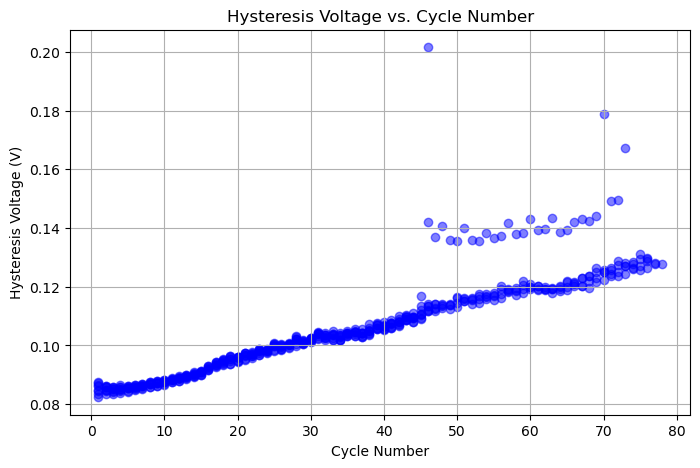

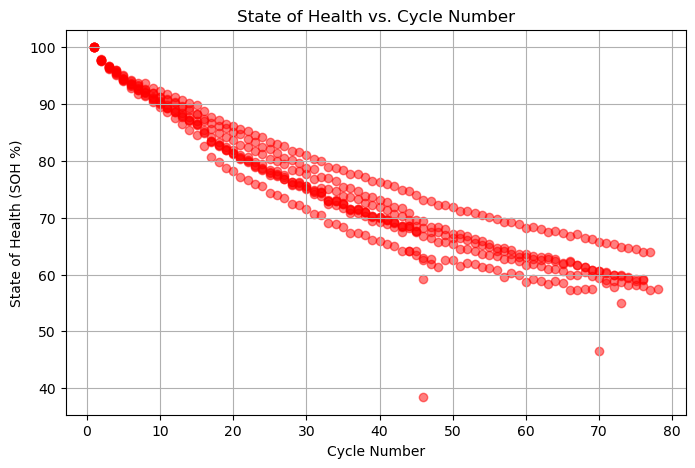

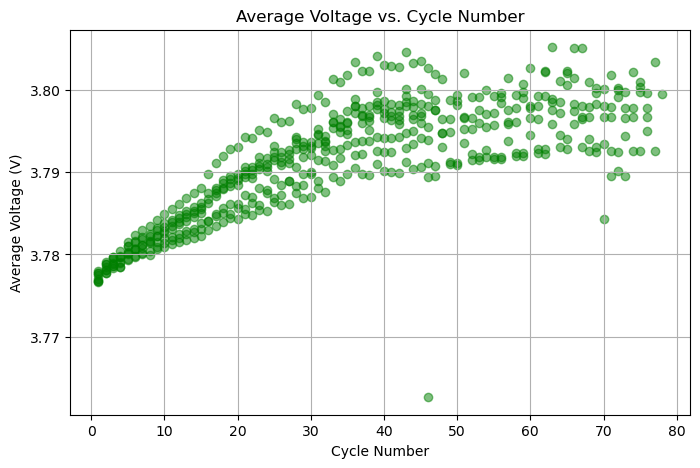

In [26]:
# ========================
# 11. Print Key Dataset Metrics (AFTER Model Training)
# ========================
print("\n Key Dataset Metrics (For Reference, Not Used in Modeling)")
print(f"Total rows in dataset: {len(full_data_filtered)}")
print(f"  Unique battery cells in dataset: {full_data_filtered['cell_number'].unique()}")
print(f"  Unique discharge cycles: {full_data_filtered['cycle_number'].nunique()}")
print(f"  Average Hysteresis Voltage: {hysteresis_df['hysteresis_voltage'].mean():.4f} V")

import matplotlib.pyplot as plt

# Plot 1: Hysteresis Voltage vs. Cycle Number
plt.figure(figsize=(8, 5))  # Create a new figure
plt.scatter(grouped['cycle_number'], grouped['hysteresis_voltage'], alpha=0.5, color='blue')
plt.xlabel('Cycle Number')
plt.ylabel('Hysteresis Voltage (V)')
plt.title('Hysteresis Voltage vs. Cycle Number')
plt.grid(True)

# Plot 2: State of Health (SOH) vs. Cycle Number
plt.figure(figsize=(8, 5))  # Create another new figure
plt.scatter(grouped['cycle_number'], grouped['SOH'], alpha=0.5, color='red')
plt.xlabel('Cycle Number')
plt.ylabel('State of Health (SOH %)')
plt.title('State of Health vs. Cycle Number')
plt.grid(True)

# Plot 3: Voltage vs. Cycle Number
plt.figure(figsize=(8, 5))
plt.scatter(grouped['cycle_number'], grouped['avg_voltage'], alpha=0.5, color='green')
plt.xlabel('Cycle Number')
plt.ylabel('Average Voltage (V)')
plt.title('Average Voltage vs. Cycle Number')
plt.grid(True)

# Show all plots at the end
plt.show()